In [4]:
import pandas as pd
import numpy as np

import json
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import wandb

sns.set_theme(style="whitegrid")


# plot as columns x=el2n_percentile, y=avg_loss_by_percentile
def plot_avg_by_percentile(avg_by_percentile, name_to_plot="loss"):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax = sns.barplot(x=avg_by_percentile.index, y=avg_by_percentile.values, ax=ax)

    ax.set_title(f"Average {name_to_plot} by percentile")
    ax.set_xlabel("Percentile")
    ax.set_ylabel(f"Average {name_to_plot}")

    return fig, ax


def plot_difference_by_perccentile(dense_scores, pruned_scores, column_to_plot="loss", **plot_kwargs):
    difference_by_percentile = (
        dense_scores.groupby("el2n_percentile")[column_to_plot].mean()
        - pruned_scores.groupby("el2n_percentile")[column_to_plot].mean()
    )

    fig, ax = plt.subplots(**plot_kwargs)
    ax = sns.barplot(
        x=difference_by_percentile.index, y=difference_by_percentile.values, ax=ax
    )
    ax.set_title(f"Dense - Pruned {column_to_plot} by EL2N percentile")
    ax.set_xlabel("Percentile")
    ax.set_ylabel(f"Difference in {column_to_plot}")

    return fig, ax


def get_run_history(project, run_id):
    api = wandb.Api()
    return api.run(f"{project}/{run_id}").history()


def plot_loss(proj, run_id, model_name, ax=None, verbose=False):
    history = get_run_history(proj, run_id)
    if verbose:
        print(history.columns)

    try:
        metrics = history[["_step", "epoch", "train/loss", "valid/loss"]]
    except KeyError:
        metrics = history[["_step", "epoch", "train/loss", "valid/loss"]]

    loss_columns = metrics.columns[2:]

    ax = (
        metrics.fillna(method="ffill")
        .groupby("epoch")
        .mean()
        .plot(y=loss_columns, ax=ax)
    )
    ax.legend([f"{c.split('/')[0]}" for c in loss_columns])
    ax.set_title(model_name)
    # y ticks every 0.01
    ax.set_yticks(np.arange(0, metrics["train/loss"].max(), 0.3))

    # horizontal line at best validation loss
    best_valid_loss = metrics["valid/loss"].min()
    index_best_valid_loss = int(metrics["epoch"][metrics["valid/loss"].idxmin()])

    ax.axhline(y=best_valid_loss, color="r", linestyle="--")
    # annotate line in bold black
    ax.text(
        0.1,
        best_valid_loss + 0.05,
        f"best valid/loss {best_valid_loss:.3f} @ {index_best_valid_loss}",
        color="black",
        weight="bold",
    )

    return ax, metrics


def plot_sparsity(proj, run_id, model_name, ax=None, verbose=False):
    history = get_run_history(proj, run_id)

    if verbose:
        print(history.columns)

    try:
        metrics = history[["_step", "epoch", "sparsity_levels._total_sparsity"]]
    except KeyError as e:
        raise KeyError("Error in metrics", e)

    sparsity_columns = metrics.columns[-1]
    # check if ax has something drawn
    is_empty = True if ax.lines else False
    ax = (
        metrics.fillna(method="ffill")
        .groupby("epoch")
        .mean()
        .plot(y=sparsity_columns, ax=ax, label=model_name)
    )

    ax.set_yticks(np.arange(0, metrics[sparsity_columns].max(), 0.3))
    
    # verical line when highest sparsity is reached
    best_sparsity = metrics[sparsity_columns].max()
    index_best_sparsity = int(metrics["epoch"][metrics[sparsity_columns].idxmax()])
    ax.axvline(x=index_best_sparsity, color="r", linestyle="--")
    # annotate line in bold black
    # check if something is already written at 1.1

    y_delta = 0.05 if is_empty else -0.05
    ax.text(
        x=index_best_sparsity + 0.1,
        y=best_sparsity + y_delta,
        s=f"highest sparsity {best_sparsity:.3f} @ {index_best_sparsity}",
        color="black",
        weight="bold",
    )
    
    return ax, metrics

In [6]:
import wandb

api = wandb.Api()

dense_project = "generalization-dense-normal_labels"
dense_name_id = {
    r._attrs["displayName"]: r._attrs["name"] for r in api.runs(dense_project)
}
print(dense_name_id.keys())

# pruning_project = "generalization-pruning-normal_labels"
# pruned_name_id = {
#     r._attrs["displayName"]: r._attrs["name"] for r in api.runs(pruning_project)
# }
# print(pruned_name_id.keys())

dict_keys(['inception-0.0', 'alexnet-0.0', 'mlp_3x512-0', 'mlp_1x512-0', 'inception-0', 'alexnet-0'])


## Losses

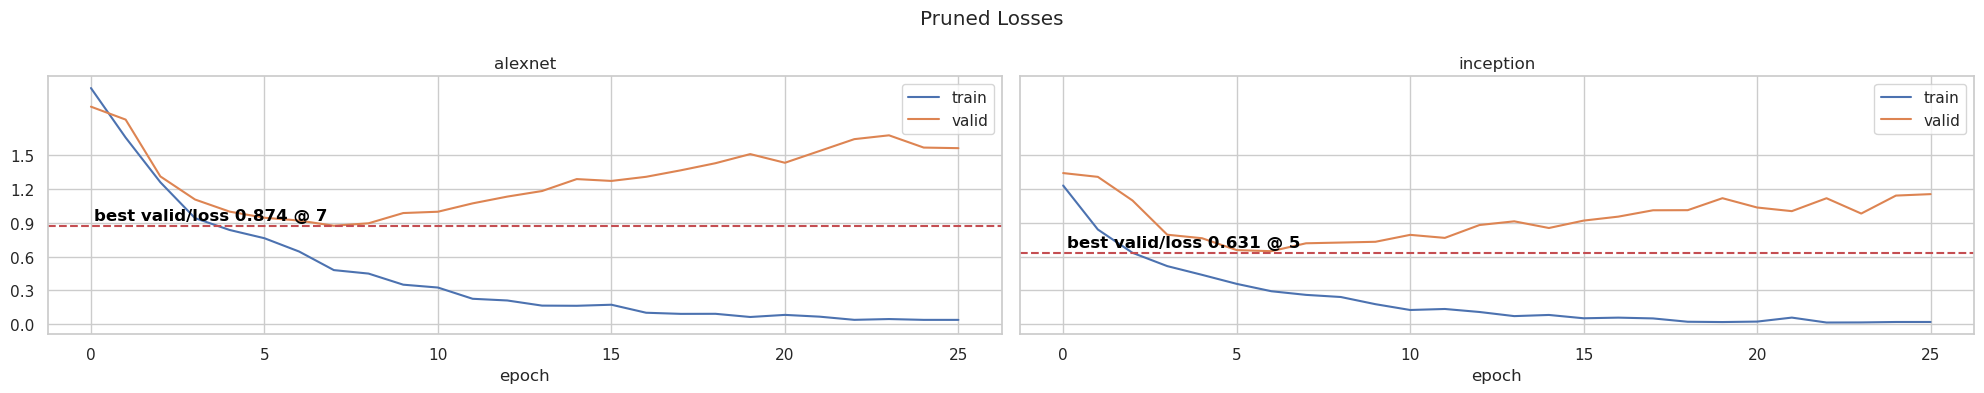

In [7]:
f, axs = plt.subplots(figsize=(20, 4), ncols=2, sharey="row", layout="tight")
ax, metrics_dense_alexnet = plot_loss(
    dense_project, dense_name_id["alexnet-0"], "alexnet", ax=axs[0]
)
ax, metrics_dense_inception = plot_loss(
    dense_project, dense_name_id["inception-0"], "inception", ax=axs[1]
)

f.suptitle("Dense Losses")
plt.savefig('./images/normal_dense_losses.png', bbox_inches='tight', dpi=300)
f.show()

# f, axs = plt.subplots(figsize=(20, 4), ncols=2, sharey=True, layout="tight")
# ax, metrics_pruned_alexnet = plot_loss(
#     pruning_project, pruned_name_id["alexnet-0.0"], "alexnet", ax=axs[0]
# )
# ax, metrics_pruned_inception = plot_loss(
#     pruning_project, pruned_name_id["inception-0.0"], "inception", ax=axs[1]
# )

f.suptitle("Pruned Losses")
plt.savefig('./images/normal_pruned_losses.png', bbox_inches='tight', dpi=300)
f.show()

## Sparsity

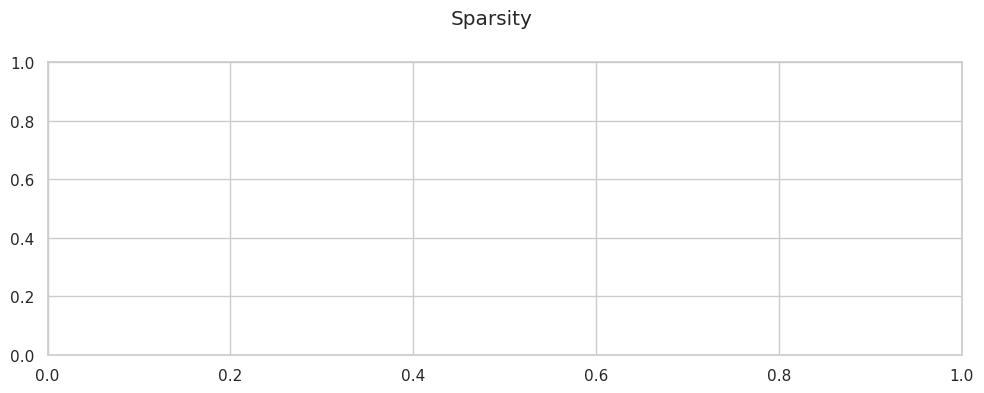

In [8]:
f, axs = plt.subplots(figsize=(10, 4), ncols=1, sharey=True, layout="tight")
# ax, metrics_pruned_alexnet = plot_sparsity(
#     pruning_project, pruned_name_id["alexnet-0.0"], "alexnet", ax=axs
# )
# ax, metrics_pruned_inception = plot_sparsity(
#     pruning_project, pruned_name_id["inception-0.0"], "inception", ax=axs
# )

# ax.legend(["alexnet", "inception"])

f.suptitle("Sparsity")
plt.savefig('./images/normal_sparsity.png', bbox_inches='tight', dpi=300)
f.show()

## Sparsity & Valid Loss

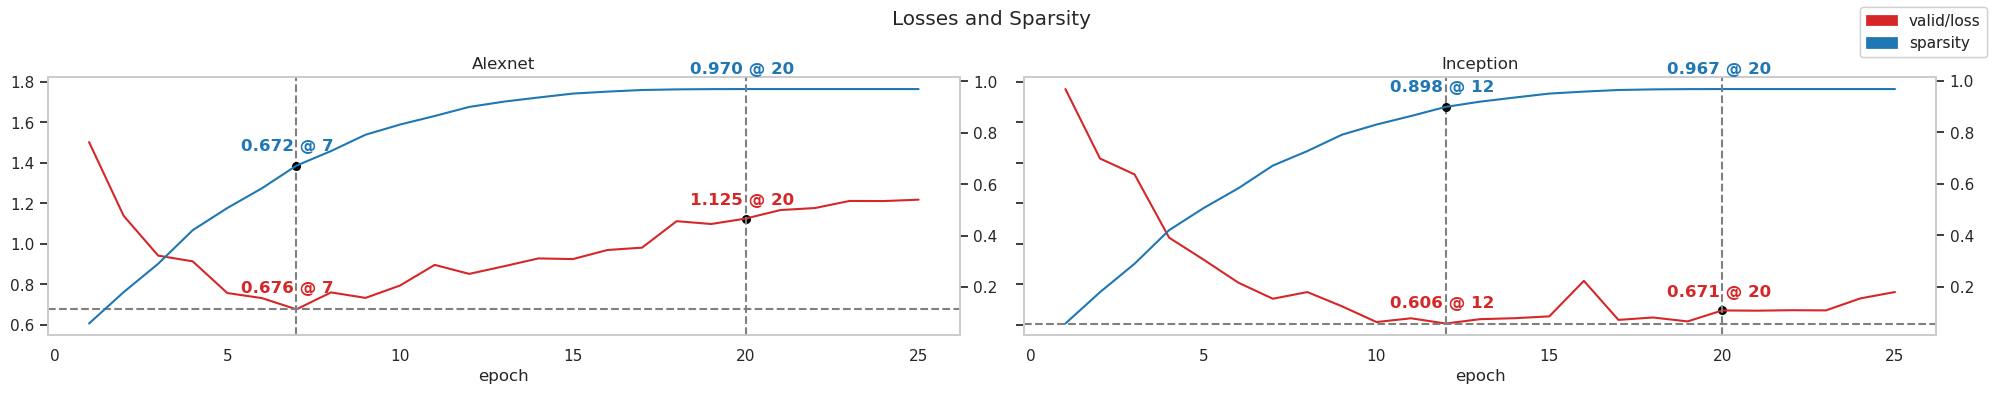

In [ ]:
from matplotlib import patches


def plot_columns(
    proj, run_id, model_name, columns, rename_cols=None, ax=None, verbose=False
):
    history = get_run_history(proj, run_id)

    if verbose:
        print(history.columns)

    try:
        metrics = history[["_step", "epoch"] + columns]
    except KeyError as e:
        raise KeyError("Error in metrics", e)

    if rename_cols:
        metrics.columns = ["_step", "epoch"] + rename_cols
        columns = rename_cols

    is_empty = True if ax.lines else False

    color1 = "tab:red"
    ax1 = (
        metrics.fillna(method="ffill")
        .groupby("epoch")
        .mean()
        .plot(y=columns[0], ax=ax, color=color1)
    )
    # remove legend
    ax1.get_legend().remove()
    ax2 = ax.twinx()
    color2 = "tab:blue"
    ax2 = (
        metrics.fillna(method="ffill")
        .groupby("epoch")
        .mean()
        .plot(y=columns[1], ax=ax2, color=color2)
    )
    ax2.get_legend().remove()

    # ### LINES AND TEXT ####
    # light grey
    color = "grey"

    # horizontal and vertical line at min col1 --> min valid loss
    best_col1 = metrics[columns[0]].min() # 0.67
    index_best_col1 = int(metrics["epoch"][metrics[columns[0]].idxmin()]) # 7
    ax1.axvline(x=index_best_col1, color=color, linestyle="--") # 7
    ax1.axhline(y=best_col1, color=color, linestyle="--") # 0.67


    # vertical line at max col2 --> max sparsity
    best_col2 = metrics[columns[1]].max() # 0.97
    index_best_col2 = int(metrics["epoch"][metrics[columns[1]].idxmax()]) # 20
    ax2.axvline(x=index_best_col2, color=color, linestyle="--")
    
    # loss value at max sparsity
    col1_value_at_best_col2 = metrics[columns[0]][metrics["epoch"] == index_best_col2].values[0] 
    # ax1.axhline(y=col1_value_at_best_col2, color=color, linestyle="--", xmin=0.8-0.08, xmax=0.81)
    # dot at loss value at max sparsity
    ax1.scatter(
        x=index_best_col2,
        y=col1_value_at_best_col2,
        color="black",
        s=30,
    )

    # sparsity value at min loss
    col2_value_at_best_col1 = metrics[columns[1]][metrics["epoch"] == index_best_col1].values[0]
    # dot at sparsity value at min loss
    ax2.scatter(
        x=index_best_col1,
        y=col2_value_at_best_col1,
        color="black",
        s=30,
    )

    # text --> best valid loss
    ax1.text(
        x=index_best_col1 - 1.6,
        y=best_col1 + 0.08,
        s=f"{best_col1:.3f} @ {index_best_col1}",
        color=color1,
        weight="bold",
    )

    # text --> sparsity at min loss
    ax2.text(
        x=index_best_col1 - 1.61,
        y=col2_value_at_best_col1 + 0.06,
        s=f"{col2_value_at_best_col1:.3f} @ {index_best_col1}",
        color=color2,
        weight="bold",
    )

    # text --> best sparsity
    ax2.text(
        x=index_best_col2 - 1.6,
        y=best_col2 + 0.06,
        s=f"{best_col2:.3f} @ {index_best_col2}",
        color=color2,
        weight="bold",
    )
    # text --> loss at max sparsity
    ax1.text(
        x=index_best_col2 - 1.6,
        y=col1_value_at_best_col2 + 0.07,
        s=f"{col1_value_at_best_col2:.3f} @ {index_best_col2}",
        color=color1,
        weight="bold",
    )

    ax1.grid(False)
    ax2.grid(False)

    if not is_empty:
        fig = ax.get_figure()
        red_patch = patches.Patch(color=color1, label=columns[0], linewidth=0.5)
        blue_patch = patches.Patch(color=color2, label=columns[1], linewidth=0.5)
        fig.legend(handles=[red_patch, blue_patch])

    return ax, metrics


f, axs = plt.subplots(figsize=(20, 4), ncols=2, sharey=True, layout="tight")

ax, metrics = plot_columns(
    pruning_project,
    pruned_name_id["alexnet-0.0"],
    "alexnet",
    columns=["valid/loss", "sparsity_levels._total_sparsity"],
    rename_cols=["valid/loss", "sparsity"],
    verbose=False,
    ax=axs[0],
)
ax.set_title("Alexnet")

ax, metrics = plot_columns(
    pruning_project,
    pruned_name_id["inception-0.0"],
    "inception",
    columns=["valid/loss", "sparsity_levels._total_sparsity"],
    rename_cols=["valid/loss", "sparsity"],
    verbose=False,
    ax=axs[1],
)
ax.set_title("Inception")

f.suptitle("Losses and Sparsity")
plt.savefig('./images/normal_losses_sparsity-optimal_best.png', bbox_inches='tight', dpi=300)
f.show()

## Full Scores

In [9]:
from generalization.utils.viz import get_scores

inception_dense_scores = get_scores(
    run_id=dense_name_id["inception-0"],
    project=dense_project,
    merge_all=True,
)
# inception_pruned_scores = get_scores(
#     run_id=pruned_name_id["inception-0.0"],
#     project=pruning_project,
#     merge_all=True,
# )

alexnet_dense_scores = get_scores(
    run_id=dense_name_id["alexnet-0"],
    project=dense_project,
    merge_all=True,
)
# alexnet_pruned_scores = get_scores(
#     run_id=pruned_name_id["alexnet-0.0"],
#     project=pruning_project,
#     merge_all=True,
# )

0it [00:00, ?it/s]
100%|██████████| 25/25 [00:06<00:00,  3.87it/s]
0it [00:00, ?it/s]
100%|██████████| 25/25 [00:06<00:00,  3.62it/s]


In [14]:
alexnet_dense_scores.sort_values(by="epoch", inplace=True)
alexnet_dense_scores.to_csv("dense_alexnet-normal_labels.csv", index=False)

In [17]:
inception_dense_scores.sort_values(by="epoch", inplace=True)
inception_dense_scores.to_csv("dense_inception-normal_labels.csv", index=False)

In [ ]:
inception_dense_scores[["epoch", "loss", "indices"]]

dict_denses_scores = dict()
for e in sorted(inception_dense_scores.epoch.unique()):
    epoch_scores = inception_dense_scores[inception_dense_scores.epoch == e]
    dict_denses_scores[int(e)] = epoch_scores[["loss", "indices"]].to_numpy()

dict_denses_scores

## Per Sample Losses

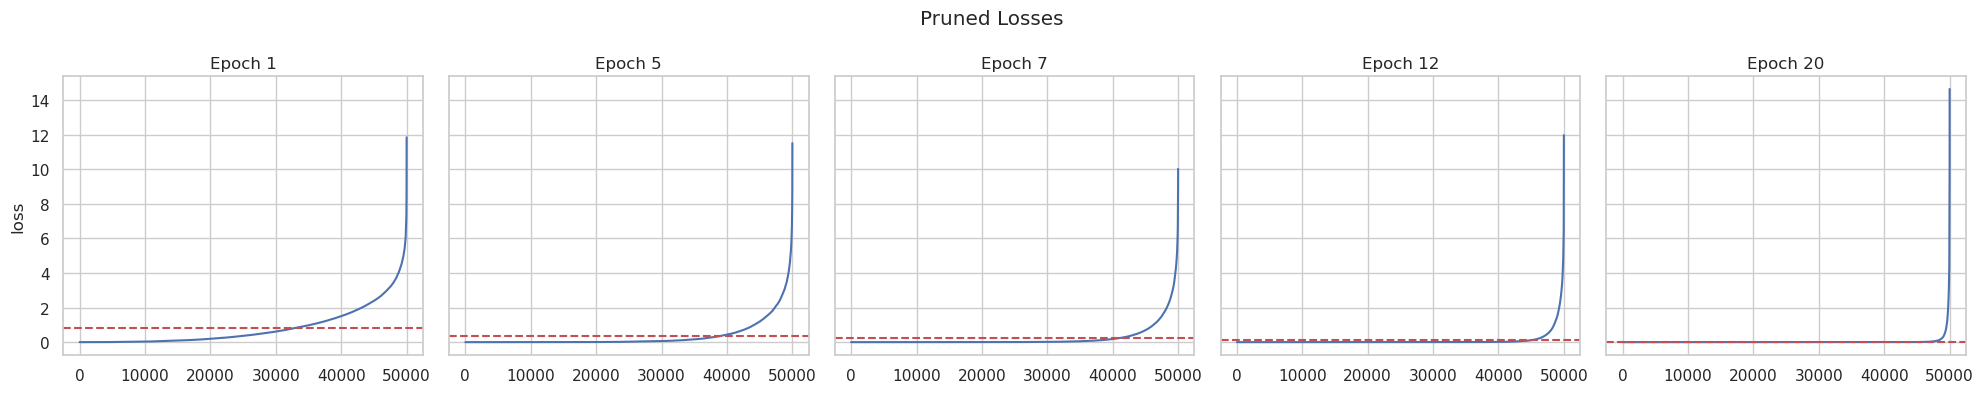

In [16]:
epochs = [1, 5, 7, 12, 20]

f, axs = plt.subplots(figsize=(20, 4), ncols=len(epochs), sharey=True, layout="tight")

apply_norm = False
apply_log = False
# plot dense sample losses
for epoch, ax in zip(epochs, axs):
    # dense_scores[dense_scores.epoch == epoch].sort_values("indices").loss.plot( ax=ax, kind="density")
    # normalize loss
    data = inception_dense_scores[inception_dense_scores.epoch == epoch].sort_values(
        "loss"
    )
    if apply_norm:
        data["loss"] = data["loss"] / data["loss"].max()
    if apply_log:
        data["loss"] = np.log(data["loss"] + 1e-10)

    sns.lineplot(
        x=np.arange(
            0, len(inception_dense_scores[inception_dense_scores.epoch == epoch])
        ),
        y="loss",
        data=data,
        ax=ax,
    )
    # dense_scores[dense_scores.epoch == epoch].sort_values("indices").plot(
    #     x="indices", y="loss", ax=ax
    # )
    avg_loss = data.loss.mean()
    # horizontal line at mean dense loss
    ax.axhline(y=avg_loss, color="r", linestyle="--")
    ax.set_title(f"Epoch {epoch}")

f.suptitle("Dense Losses")
plt.savefig("./images/inception-dense_sample_loss.png", bbox_inches="tight", dpi=300)


# f, axs = plt.subplots(figsize=(20, 4), ncols=len(epochs), sharey=True, layout="tight")

# # plot pruned sample losses
# for epoch, ax in zip(epochs, axs):
#     # pruned_scores[pruned_scores.epoch == epoch].sort_values("indices").loss.plot( ax=ax, kind="density")
#     data = pruned_scores[pruned_scores.epoch == epoch].sort_values("loss")
#     if apply_norm:
#         data["loss"] = data["loss"] / data["loss"].max()
#     # add noise
#     if apply_log:
#         data["loss"] = np.log(data["loss"] + 1e-10)
#     # if apply_log: data["loss"] = np.log(data["loss"] + 1e-10) +
#     sns.lineplot(
#         x=np.arange(0, len(pruned_scores[pruned_scores.epoch == epoch])),
#         y="loss",
#         data=data,
#         ax=ax,
#     )
#     avg_loss = data.loss.mean()
#     # horizontal line at mean pruned loss
#     ax.axhline(y=avg_loss, color="r", linestyle="--")
#     ax.set_title(f"Epoch {epoch}")

f.suptitle("Pruned Losses")
plt.savefig("./images/inception-pruned_dsample_loss.png", bbox_inches="tight", dpi=300)

plt.show()

## EL2N

In [27]:
import torch
import torch.nn.functional as F


def compute_el2n_scores(logits, y, num_classes=10):
    """Compute EL2N scores.

    Parameters:
        outputs: Torch.Tensor
            Logits from the model
        y: Torch.Tensor
            Corresponding labels
        num_classes: int
            Number of classes in the dataset. Default: 10.

    Returns:
        scores: Torch.Tensor
    """
    if not torch.is_tensor(logits):
        logits = torch.tensor(logits)
    if not torch.is_tensor(y):
        y = torch.tensor(y)

    probs, targets = F.softmax(logits, dim=-1), F.one_hot(y, num_classes=num_classes)
    scores = torch.linalg.vector_norm(probs - targets, dim=-1)
    return scores.cpu()


custom_to_numpy = lambda df, col: np.array(df[col].values.tolist())

def pd_compute_el2n(df):
    logits = custom_to_numpy(df, "logits")
    targets = custom_to_numpy(df, "target")
    return compute_el2n_scores(logits, targets, num_classes=10).numpy()

dense_scores["el2n"] = pd_compute_el2n(dense_scores)
pruned_scores["el2n"] = pd_compute_el2n(pruned_scores)

alexnet_dense_scores["el2n"] = pd_compute_el2n(alexnet_dense_scores)
alexnet_pruned_scores["el2n"] = pd_compute_el2n(alexnet_pruned_scores)

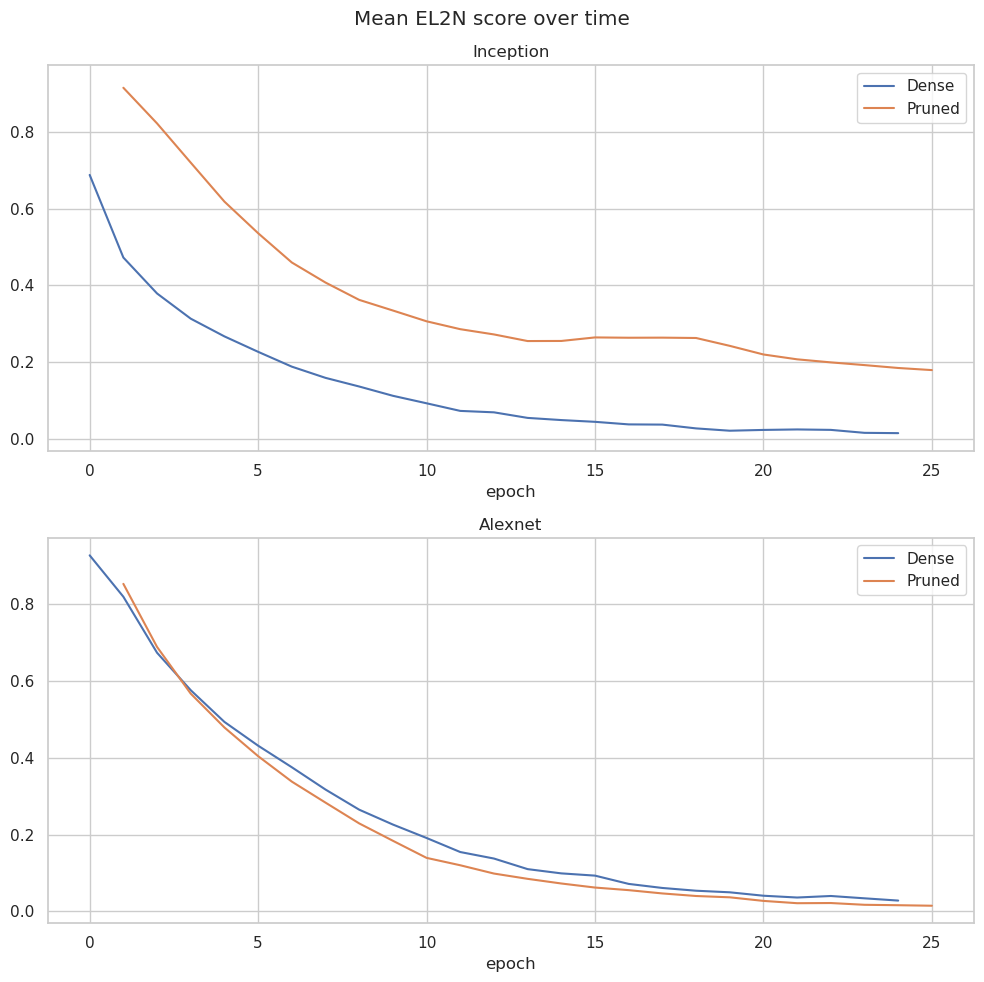

In [35]:
f, axs = plt.subplots(figsize=(10, 10), ncols=1, nrows=2, sharey=True, layout="tight")

dense_scores.groupby("epoch").el2n.mean().plot(ax=axs[0])
pruned_scores.groupby("epoch").el2n.mean().plot(ax=axs[0])
axs[0].legend(["Dense", "Pruned"])
axs[0].set_title("Inception")

alexnet_dense_scores.groupby("epoch").el2n.mean().plot(ax=axs[1])
alexnet_pruned_scores.groupby("epoch").el2n.mean().plot(ax=axs[1])
axs[1].legend(["Dense", "Pruned"])
axs[1].set_title("Alexnet")

plt.suptitle("Mean EL2N score over time")
plt.savefig('./images/normal_el2n.png', bbox_inches='tight', dpi=300)
plt.show()

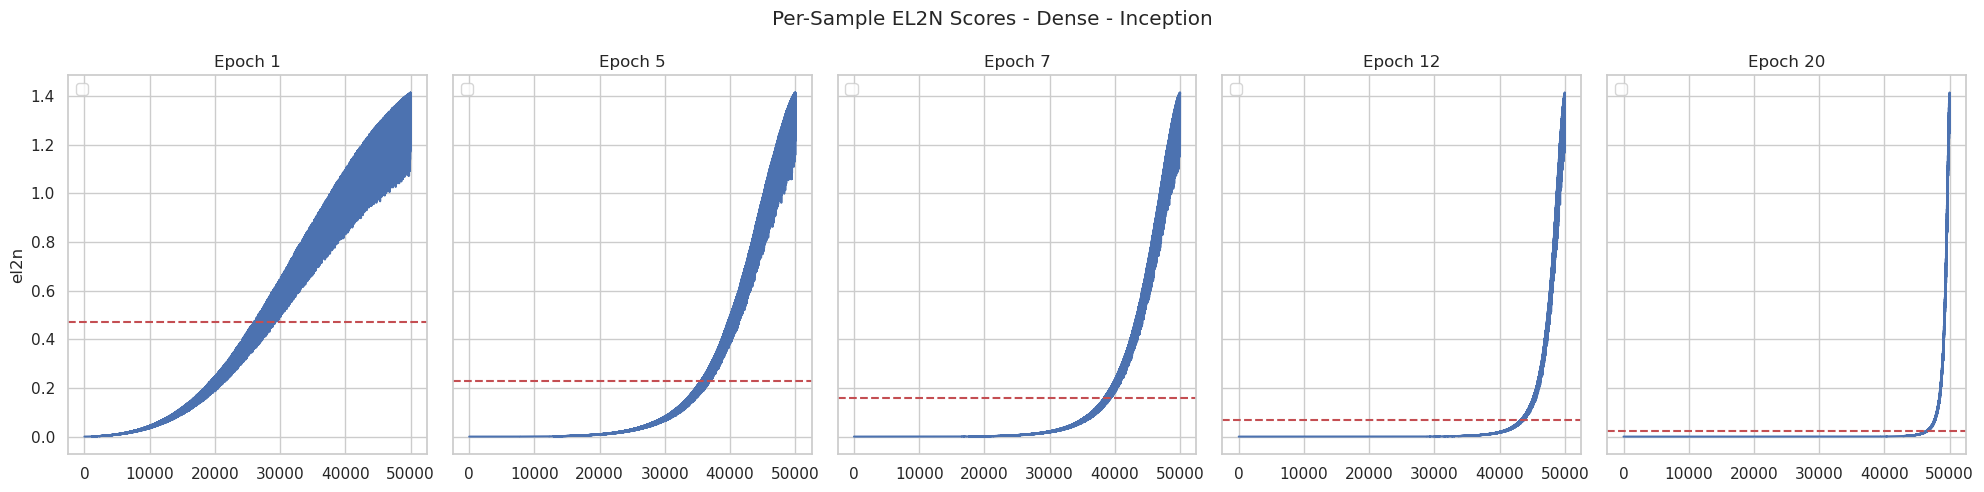

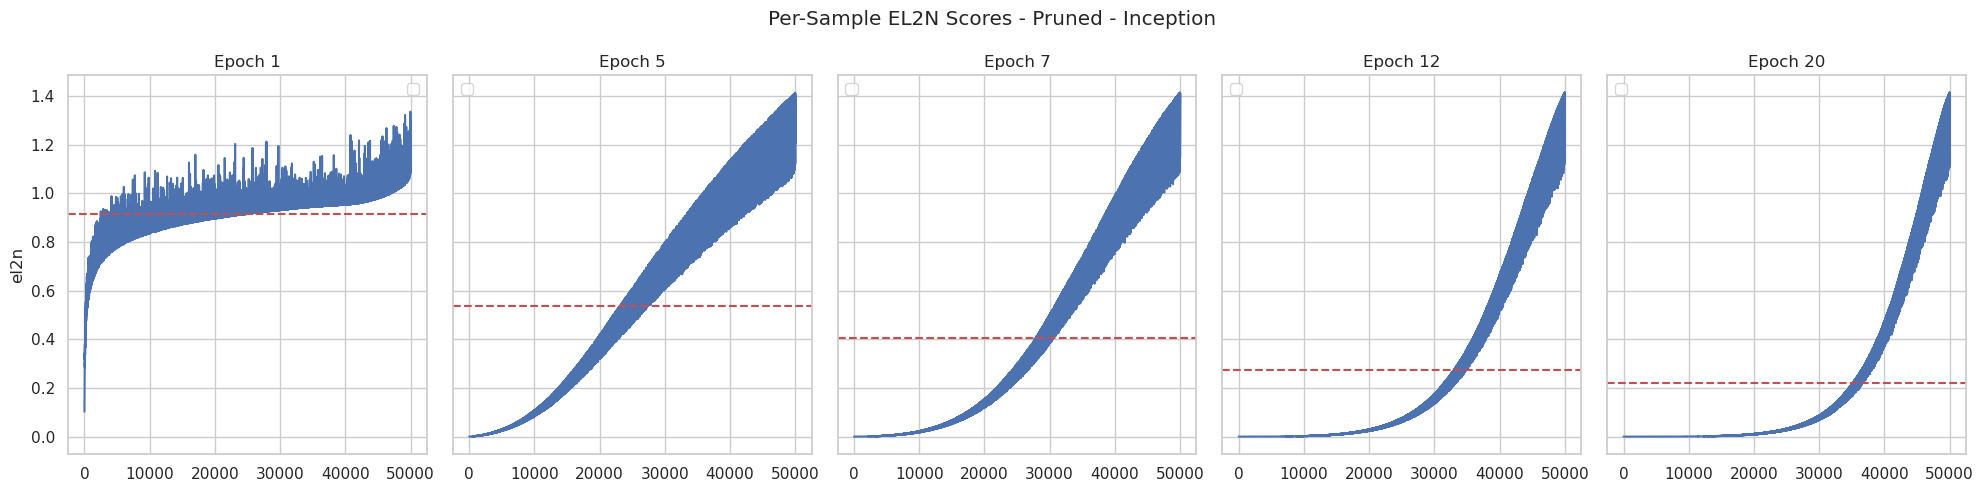

: 

In [40]:
epochs = [1, 5, 7, 12, 20]

f, axs = plt.subplots(figsize=(20, 5), ncols=len(epochs), nrows=1, sharey=True, layout="tight")

apply_norm = False
apply_log = False
# plot dense sample losses
for epoch, ax in zip(epochs, axs):
    # dense_scores[dense_scores.epoch == epoch].sort_values("indices").loss.plot( ax=ax, kind="density")
    data = dense_scores[dense_scores.epoch == epoch].sort_values("loss")

    if apply_norm: data["loss"] = data["loss"] / data["loss"].max()
    if apply_log: data["loss"] = np.log(data["loss"] + 1e-10)

    sns.lineplot(
        x=np.arange(0, len(dense_scores[dense_scores.epoch == epoch])),
        y="el2n",
        data=data,
        ax=ax,
    )

    avg_loss = data.el2n.mean()
    # horizontal line at mean dense loss
    ax.axhline(y=avg_loss, color='r', linestyle='--')
    ax.set_title(f"Epoch {epoch}")
    ax.legend([])

f.suptitle("Per-Sample EL2N Scores - Dense - Inception")
plt.savefig('./images/inception-dense-sample_el2n.png', bbox_inches='tight', dpi=300)

f, axs = plt.subplots(figsize=(20, 5), ncols=len(epochs), nrows=1, sharey=True, layout="tight")
# plot pruned sample losses
for epoch, ax in zip(epochs, axs):
    data = pruned_scores[pruned_scores.epoch == epoch].sort_values("loss")
    if apply_norm: data["loss"] = data["loss"] / data["loss"].max()
    if apply_log: data["loss"] = np.log(data["loss"] + 1e-10)

    # pruned_scores[pruned_scores.epoch == epoch].sort_values("indices").loss.plot( ax=ax, kind="density")
    sns.lineplot(
        x=np.arange(0, len(pruned_scores[pruned_scores.epoch == epoch])),
        y="el2n",
        data=data,
        ax=ax,
    )

    avg_loss = data.el2n.mean()
    # horizontal line at mean pruned loss
    ax.axhline(y=avg_loss, color='r', linestyle='--')
    ax.set_title(f"Epoch {epoch}")
    # delete legend
    ax.legend([])

f.suptitle("Per-Sample EL2N Scores - Pruned - Inception")
plt.savefig('./images/inception-pruned-sample_el2n.png', bbox_inches='tight', dpi=300)
plt.show()

In [174]:
import gzip
from tqdm import tqdm
from generalization.randomization import build_cifar10

cifar = build_cifar10(corruption_name="normal_labels")
train_compressed_mb = []

for i in tqdm(data['indices']):
    image, label, index = cifar[0][i]
    image_bytes = gzip.compress(image.numpy().tobytes())

    compressed_size_mb = len(image_bytes) / 1e6
    train_compressed_mb.append(compressed_size_mb)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 50000/50000 [00:14<00:00, 3461.95it/s]


In [200]:
f, ax = plt.subplots(figsize=(12, 8))
epochs = [20]

col = "loss"

for epoch in epochs:
    data = dense_scores[dense_scores.epoch == epoch].sort_values("loss")
    corr = np.corrcoef(data[col], train_compressed_mb)[0, 1]
    sns.histplot(x=col, y=train_compressed_mb, data=data, ax=ax, label=f"Epoch {epoch} - Corr: {corr:.3f}")

f, ax = plt.subplots(figsize=(12, 8))
for epoch in epochs:
    data = pruned_scores[pruned_scores.epoch == epoch].sort_values("loss")
    corr = np.corrcoef(data[col], train_compressed_mb)[0, 1]
    sns.histplot(x=col, y=train_compressed_mb, data=data, ax=ax, label=f"Epoch {epoch} - Corr: {corr:.3f}")

: 

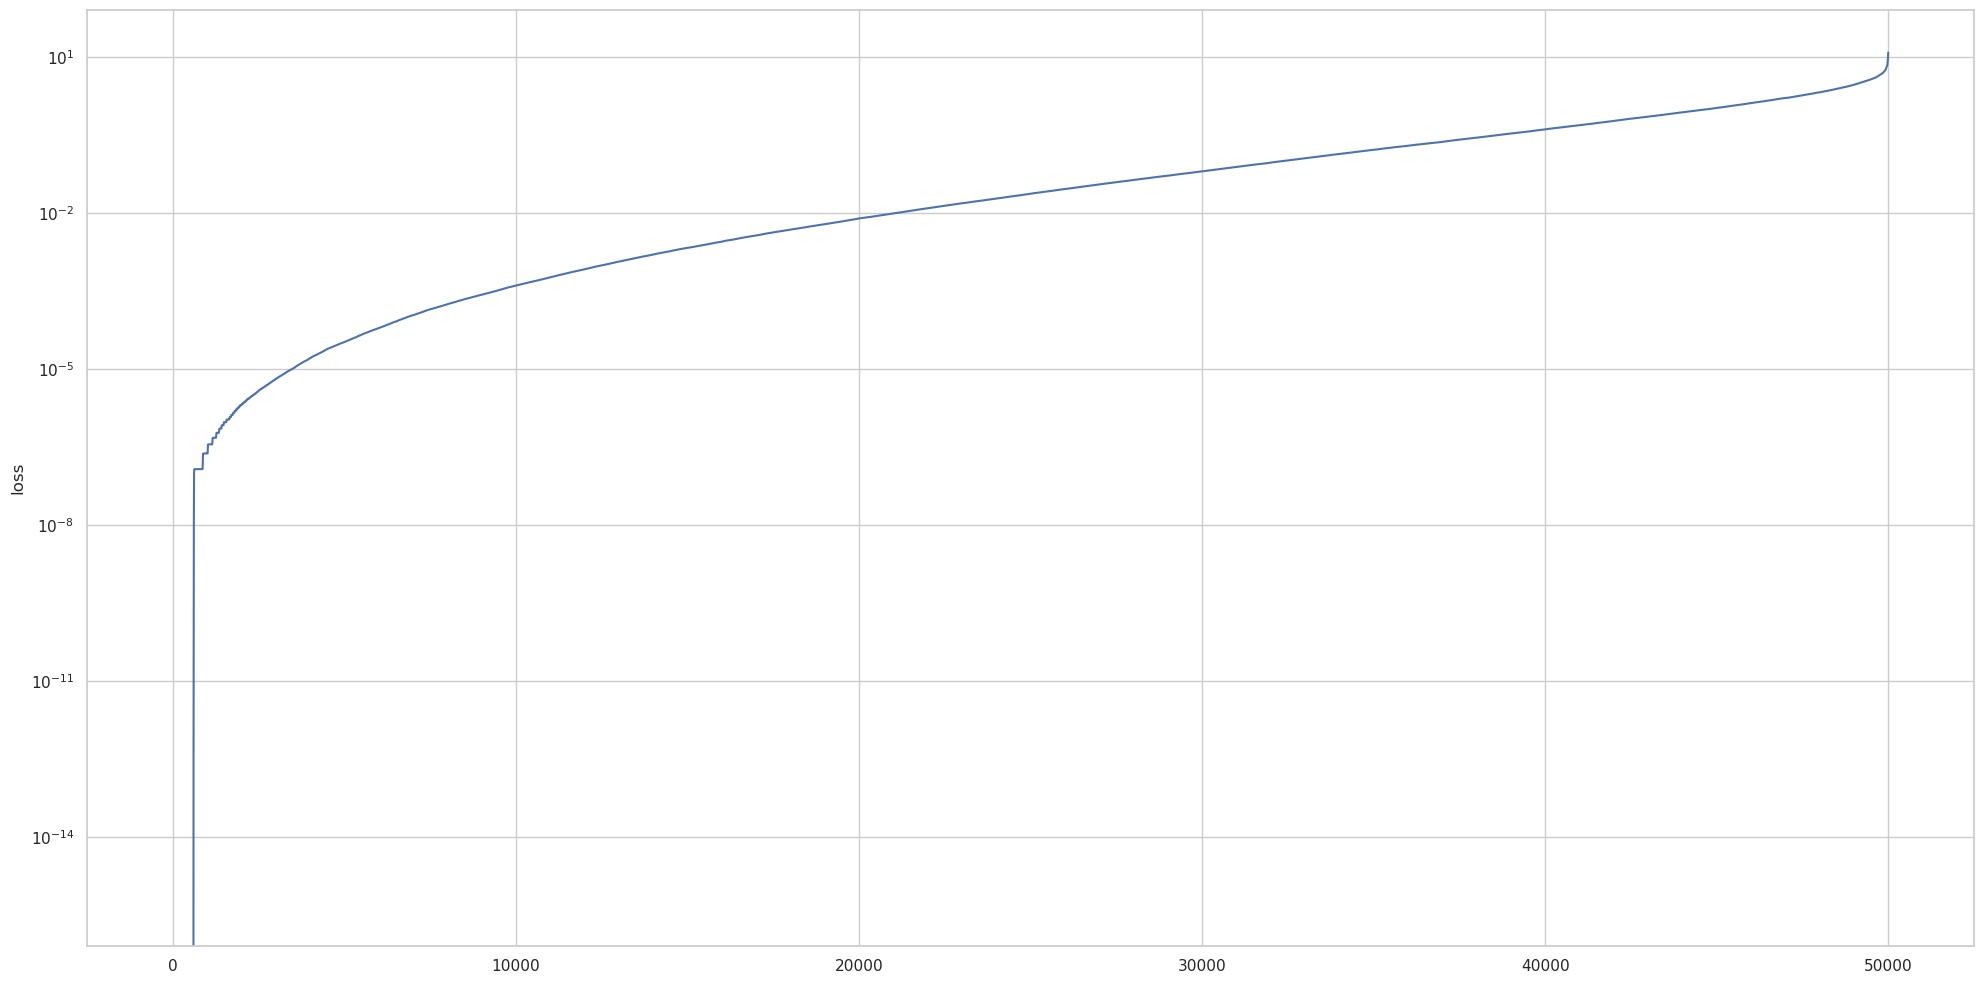

In [169]:
from scipy.ndimage import gaussian_filter1d
# how different are the compressed size vs the sample loss
toplotdata = data
toplotdata["compressed_size_mb"] = gaussian_filter1d(1 - np.array(train_compressed_mb), sigma=2)
toplotdata['loss'] = gaussian_filter1d(toplotdata['loss'], sigma=2)

f, ax = plt.subplots(figsize=(20, 10), ncols=1, nrows=1, sharey=True, layout="tight")

# ax = sns.lineplot(x=np.arange(0, len(data)), y="compressed_size_mb", data=data, ax=ax, label="Compressed size")
ax = sns.lineplot(x=np.arange(0, len(data)), y="loss", data=toplotdata, ax=ax)
ax.set_yscale('log')